In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('csv/processed_tickets_en.csv')
df.head()

,processed_text,type,queue,priority,urgency
0,Urgent: Critical impact on enterprise network ...,Incident,Technical Support,high,urgent
1,Intermittent Cursor Freezing Issue on Dell XPS...,Incident,Product Support,low,not_urgent
2,Urgent: Support needed for data recovery of My...,Incident,Technical Support,high,urgent
3,Inquiry about MacBook Air M1 features. Dear Cu...,Request,Sales and Pre-Sales,low,not_urgent
4,Request Assistance with Office 365 Installatio...,Problem,Technical Support,medium,not_urgent


In [21]:
df_hf = pd.read_csv('csv/hf_priority.csv')
df_hf.head()

,label,processed_text,priority,urgency
0,2,This is a critical issue.,high,urgent
1,1,This is a moderate issue.,medium,not_urgent
2,0,This is a minor issue.,low,not_urgent
3,2,This issue requires immediate attention.,high,urgent
4,1,This issue should be addressed soon.,medium,not_urgent


In [22]:
# concat the two dataframes vertically
df_combined = pd.concat([df, df_hf], axis=0)
df_combined.reset_index(drop=True, inplace=True)

# check the shape of the new dataframe
df_combined.shape

(8649, 6)

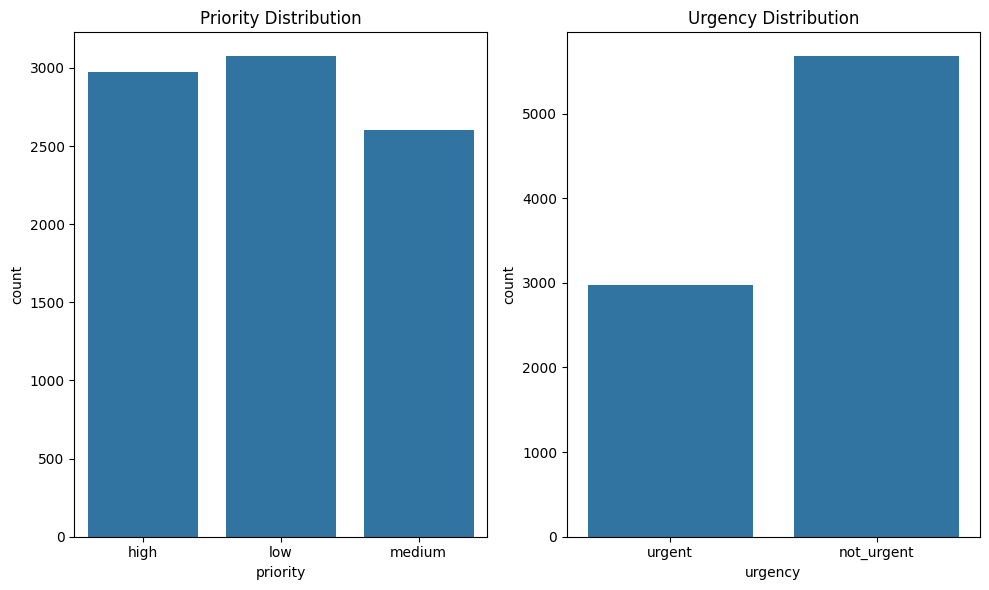

In [26]:
# visualize data
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Check the distribution of the labels
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(x='priority', data=df_combined, ax=axs[0])
axs[0].set_title('Priority Distribution')
sns.countplot(x='urgency', data=df_combined, ax=axs[1])
axs[1].set_title('Urgency Distribution')
plt.tight_layout()


### Using Priority as feature 

In [23]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for each sentence
def get_bert_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        # Tokenize the sentence
        inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Get the BERT embeddings (output of the last hidden layer)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            last_hidden_state = outputs.last_hidden_state  # shape: [batch_size, seq_length, hidden_size]
        
        # Use the [CLS] token's embedding as the sentence representation
        cls_embedding = last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    
    return np.vstack(embeddings)




In [27]:
data = df_combined['processed_text'].tolist()

# Get BERT embeddings
X_bert = get_bert_embeddings(data)

KeyboardInterrupt: 

In [88]:
from sklearn.model_selection import train_test_split
X = df['processed_text']
y = df['urgency']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
 
# Load BERT tokenizer and model
model_name = "bert-base-uncased"  # You can replace this with other models like 'roberta-base' or 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
 
# Function to tokenize and generate BERT embeddings
def bert_vectorize(texts):
    """
    Converts a list of texts into BERT embeddings.
    :param texts: List of text strings
    :return: Numpy array of embeddings
    """
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the mean of the token embeddings (pooled output) for the final sentence representation
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.numpy()
 
# Convert your dataset to BERT embeddings
X_train_bert = bert_vectorize(X_train.values.tolist())
X_test_bert = bert_vectorize(X_test.values.tolist())
 
# Check the shapes of the resulting arrays
print("X_train_bert shape:", X_train_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)
 
 
# Load BERT tokenizer and model
model_name = "bert-base-uncased"  # You can replace this with other models like 'roberta-base' or 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
 
# Function to tokenize and generate BERT embeddings
def bert_vectorize(texts):
    """
    Converts a list of texts into BERT embeddings.
    :param texts: List of text strings
    :return: Numpy array of embeddings
    """
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the mean of the token embeddings (pooled output) for the final sentence representation
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.numpy()
 
# Convert your dataset to BERT embeddings
X_train_bert = bert_vectorize(X_train.values.tolist())
X_test_bert = bert_vectorize(X_test.values.tolist())
 
# Check the shapes of the resulting arrays
print("X_train_bert shape:", X_train_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Example of adding TF-IDF features (you can skip this if you already have them)
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(data).toarray()

# Combine BERT embeddings with TF-IDF features
X_combined = np.hstack([X_tfidf, X_bert])


In [6]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

y = df['urgency'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

  not_urgent       0.96      0.93      0.94       156
      urgent       0.93      0.96      0.95       157

    accuracy                           0.95       313
   macro avg       0.95      0.95      0.95       313
weighted avg       0.95      0.95      0.95       313

SVM Classification Report:
              precision    recall  f1-score   support

  not_urgent       1.00      0.97      0.98       156
      urgent       0.97      1.00      0.98       157

    accuracy                           0.98       313
   macro avg       0.98      0.98      0.98       313
weighted avg       0.98      0.98      0.98       313



In [83]:
# Example prediction
# New example text to test the model
example_text = [
    "we need to find the dataset ourselves based on the use case",
    "Are we instructed anything on POC?",
    "I am not able to access the data in the shared folder",
    "nicee emergency and non emergency",
    "rasied pr for bug fixes. let me know when it is approved. no hurry",
    "once everything works fine we will push to stage"
]

# Get BERT embeddings
X_bert_example = get_bert_embeddings(example_text)

# Get TF-IDF features
X_tfidf_example = vectorizer.transform(example_text).toarray()

# Combine BERT embeddings with TF-IDF features
X_combined_example = np.hstack([X_tfidf_example, X_bert_example])


In [84]:
# make prediction
# Predict with Logistic Regression model
y_pred_logreg_example = logreg_model.predict(X_combined_example)
print("Logistic Regression Prediction :", y_pred_logreg_example)

Logistic Regression Prediction : ['not_urgent' 'not_urgent' 'not_urgent' 'not_urgent' 'urgent' 'not_urgent']


In [85]:
y_pred_svm_example = svm_model.predict(X_combined_example)
print("SVM Prediction (0: Non-Urgent, 1: Urgent):", y_pred_svm_example)

SVM Prediction (0: Non-Urgent, 1: Urgent): ['not_urgent' 'not_urgent' 'urgent' 'not_urgent' 'not_urgent' 'not_urgent']


In [ ]:
## Using BERT
from sklearn.base import BaseEstimator, TransformerMixin
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
 
 
class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model='bert-base-nli-mean-tokens'):
        self.model_name = model
        self.model = SentenceTransformer(self.model_name)
 
    def fit(self, X, y=None):
        # No training is required for SentenceTransformer
        return self
 
    def transform(self, X):
        # Ensure X is converted to a list of strings
        if isinstance(X, np.ndarray):
            X = X.tolist()
        elif isinstance(X, pd.Series):  # If input is a pandas series
            X = X.to_list()
 
        # Generate sentence embeddings
        embeddings = self.model.encode(X, show_progress_bar=False)
        return np.array(embeddings)  # Ensure the output is a numpy array
# Define pipeline with BERT vectorizer and XGBoost
pipeline = Pipeline([
    ('bert_vectorizer', BertTransformer()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train_urgency, y_train_urgency)

# Make predictions
y_pred = pipeline.predict(X_test_urgency)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test_urgency, y_pred))
transformer = BertTransformer()

transformer.fit(X_train_urgency['text'])

X_train_transformed = transformer.transform(X_train_urgency['text'])
X_test_transformed = transformer.transform(X_test_urgency['text'])

model = RandomForestClassifier(random_state=42)

model.fit(X_train_transformed, y_train_urgency)

y_pred = model.predict(X_test_transformed)

print("Classification Report:\n", classification_report(y_test_urgency, y_pred))
# example 
example_text = pd.DataFrame(
   { 'texts': [
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    'labels': [1, 1, 0, 1, 1, 0, 1, 1, 0, 0]}
)

example_text_transformed = transformer.transform(example_text['texts'])

print(f"Prediction: \n{model.predict(example_text_transformed)}")
print(f"Classification Report: \n{classification_report(example_text['labels'], model.predict(example_text_transformed))}")